In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full.bin"

In [2]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [3]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [4]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_cleaned.csv')

In [5]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [6]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 3


0

In [7]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3432
3432
3432


In [8]:
print(max(map(lambda x: len(x), sentences)))

80


In [94]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=83):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                mask[sx, wx] = 1
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [101]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out

In [43]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=83)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [102]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2745
valid samples:687


In [103]:
history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]



epoch 0
	train_loss:1.016 valid_loss:0.883
	train_acc:67.81% valid_acc:87.58%
	train_f1:0.754 valid_f1:0.857
	train_confusion_matrix:
[[28732  1616  7666]
 [ 2417   277   870]
 [ 1304   107   439]]
	valid_confusion_matrix:
[[9746   15   19]
 [ 881    4    9]
 [ 459    0    4]]


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]



epoch 1
	train_loss:0.764 valid_loss:0.629
	train_acc:87.42% valid_acc:87.79%
	train_f1:0.854 valid_f1:0.857
	train_confusion_matrix:
[[37935    22    68]
 [ 3525    12    11]
 [ 1830     8     6]]
	valid_confusion_matrix:
[[9773    2    5]
 [ 890    3    1]
 [ 462    0    1]]


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



epoch 2
	train_loss:0.525 valid_loss:0.438
	train_acc:87.42% valid_acc:87.82%
	train_f1:0.853 valid_f1:0.857
	train_confusion_matrix:
[[37939     4    27]
 [ 3578     5     2]
 [ 1845     4     3]]
	valid_confusion_matrix:
[[9778    0    2]
 [ 893    1    0]
 [ 462    0    1]]


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



epoch 3
	train_loss:0.424 valid_loss:0.418
	train_acc:87.51% valid_acc:87.82%
	train_f1:0.854 valid_f1:0.857
	train_confusion_matrix:
[[37932     2    12]
 [ 3551     3     0]
 [ 1846     1     1]]
	valid_confusion_matrix:
[[9778    0    2]
 [ 893    1    0]
 [ 462    0    1]]


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]



epoch 4
	train_loss:0.407 valid_loss:0.403
	train_acc:87.49% valid_acc:87.76%
	train_f1:0.853 valid_f1:0.857
	train_confusion_matrix:
[[37921     1     9]
 [ 3581     3     0]
 [ 1830     1     0]]
	valid_confusion_matrix:
[[9771    7    2]
 [ 892    2    0]
 [ 462    0    1]]


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]



epoch 5
	train_loss:0.396 valid_loss:0.392
	train_acc:87.51% valid_acc:87.80%
	train_f1:0.854 valid_f1:0.858
	train_confusion_matrix:
[[37925     5     5]
 [ 3559    17     0]
 [ 1847     1     0]]
	valid_confusion_matrix:
[[9771    9    0]
 [ 888    6    0]
 [ 461    1    1]]


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]



epoch 6
	train_loss:0.384 valid_loss:0.382
	train_acc:87.67% valid_acc:87.88%
	train_f1:0.857 valid_f1:0.861
	train_confusion_matrix:
[[38064    13     1]
 [ 3494    52     0]
 [ 1849     3     0]]
	valid_confusion_matrix:
[[9767   13    0]
 [ 875   19    0]
 [ 459    3    1]]


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]



epoch 7
	train_loss:0.373 valid_loss:0.372
	train_acc:87.81% valid_acc:87.98%
	train_f1:0.862 valid_f1:0.865
	train_confusion_matrix:
[[38088    34     1]
 [ 3431   150     0]
 [ 1828    15     1]]
	valid_confusion_matrix:
[[9754   26    0]
 [ 851   43    0]
 [ 454    8    1]]


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]



epoch 8
	train_loss:0.362 valid_loss:0.362
	train_acc:88.03% valid_acc:88.14%
	train_f1:0.869 valid_f1:0.870
	train_confusion_matrix:
[[37950    78     1]
 [ 3286   295     0]
 [ 1790    46     1]]
	valid_confusion_matrix:
[[9744   36    0]
 [ 823   71    0]
 [ 444   18    1]]


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 9
	train_loss:0.351 valid_loss:0.352
	train_acc:88.29% valid_acc:88.39%
	train_f1:0.875 valid_f1:0.877
	train_confusion_matrix:
[[37963   120     1]
 [ 3129   424     0]
 [ 1775    64     1]]
	valid_confusion_matrix:
[[9734   46    0]
 [ 785  109    0]
 [ 437   25    1]]


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]



epoch 10
	train_loss:0.343 valid_loss:0.342
	train_acc:88.59% valid_acc:88.61%
	train_f1:0.883 valid_f1:0.883
	train_confusion_matrix:
[[37879   168     1]
 [ 2950   624     0]
 [ 1749    92     1]]
	valid_confusion_matrix:
[[9722   58    0]
 [ 749  145    0]
 [ 429   33    1]]


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]



epoch 11
	train_loss:0.332 valid_loss:0.332
	train_acc:88.79% valid_acc:88.71%
	train_f1:0.888 valid_f1:0.887
	train_confusion_matrix:
[[37807   222     0]
 [ 2803   769     0]
 [ 1721   123     1]]
	valid_confusion_matrix:
[[9702   78    0]
 [ 716  178    0]
 [ 427   36    0]]


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



epoch 12
	train_loss:0.323 valid_loss:0.322
	train_acc:88.94% valid_acc:88.79%
	train_f1:0.892 valid_f1:0.890
	train_confusion_matrix:
[[37639   274     0]
 [ 2680   910     0]
 [ 1673   166     1]]
	valid_confusion_matrix:
[[9684   96    0]
 [ 689  205    0]
 [ 423   40    0]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 13
	train_loss:0.312 valid_loss:0.313
	train_acc:89.14% valid_acc:88.84%
	train_f1:0.897 valid_f1:0.892
	train_confusion_matrix:
[[37700   363     0]
 [ 2521  1066     0]
 [ 1628   213     1]]
	valid_confusion_matrix:
[[9671  109    0]
 [ 671  223    0]
 [ 421   42    0]]


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



epoch 14
	train_loss:0.303 valid_loss:0.303
	train_acc:89.20% valid_acc:88.99%
	train_f1:0.899 valid_f1:0.896
	train_confusion_matrix:
[[37548   381     1]
 [ 2449  1125     1]
 [ 1621   228     1]]
	valid_confusion_matrix:
[[9650  129    1]
 [ 633  261    0]
 [ 415   48    0]]


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



epoch 15
	train_loss:0.292 valid_loss:0.295
	train_acc:89.43% valid_acc:89.05%
	train_f1:0.903 valid_f1:0.897
	train_confusion_matrix:
[[37597   411     3]
 [ 2336  1239     2]
 [ 1595   242     4]]
	valid_confusion_matrix:
[[9652  126    2]
 [ 629  265    0]
 [ 413   50    0]]


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



epoch 16
	train_loss:0.283 valid_loss:0.285
	train_acc:89.56% valid_acc:89.31%
	train_f1:0.905 valid_f1:0.902
	train_confusion_matrix:
[[37661   410     7]
 [ 2285  1282     4]
 [ 1583   250    10]]
	valid_confusion_matrix:
[[9641  132    7]
 [ 590  304    0]
 [ 403   58    2]]


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



epoch 17
	train_loss:0.275 valid_loss:0.277
	train_acc:89.76% valid_acc:89.55%
	train_f1:0.909 valid_f1:0.906
	train_confusion_matrix:
[[37524   460    16]
 [ 2136  1435     8]
 [ 1553   272    19]]
	valid_confusion_matrix:
[[9638  134    8]
 [ 565  329    0]
 [ 396   61    6]]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]



epoch 18
	train_loss:0.266 valid_loss:0.271
	train_acc:90.02% valid_acc:89.69%
	train_f1:0.912 valid_f1:0.907
	train_confusion_matrix:
[[37524   442    23]
 [ 2065  1500     9]
 [ 1532   259    37]]
	valid_confusion_matrix:
[[9635  137    8]
 [ 550  344    0]
 [ 394   59   10]]


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


epoch 19
	train_loss:0.261 valid_loss:0.265
	train_acc:90.20% valid_acc:89.99%
	train_f1:0.915 valid_f1:0.911
	train_confusion_matrix:
[[37476   480    25]
 [ 1954  1608    16]
 [ 1497   280    63]]
	valid_confusion_matrix:
[[9637  129   14]
 [ 528  360    6]
 [ 378   60   25]]


(0.85, 1.0)

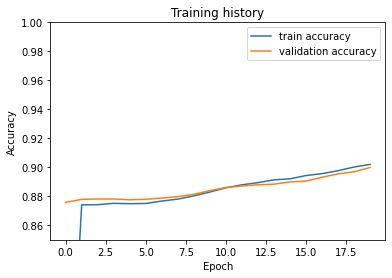

In [104]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.85, 1])

In [106]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full.bin


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

              precision    recall  f1-score   support

     Neutral       0.91      0.99      0.95      9780
    Positive       0.66      0.40      0.50       894
    Negative       0.56      0.05      0.10       463

    accuracy                           0.90     11137
   macro avg       0.71      0.48      0.52     11137
weighted avg       0.88      0.90      0.88     11137

